<a href="https://colab.research.google.com/github/arunbalu2002/Deep_fake_detection/blob/main/Deepfake_vision_mamba_(2).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!unzip /content/DeepFakeDataset.zip -d /content/Dataset

Archive:  /content/DeepFakeDataset.zip
   creating: /content/Dataset/Dataset/
   creating: /content/Dataset/Dataset/train/
   creating: /content/Dataset/Dataset/train/fake/
  inflating: /content/Dataset/Dataset/train/fake/aagfhgtpmv_0.png  
  inflating: /content/Dataset/Dataset/train/fake/aagfhgtpmv_1.png  
  inflating: /content/Dataset/Dataset/train/fake/aagfhgtpmv_2.png  
  inflating: /content/Dataset/Dataset/train/fake/aagfhgtpmv_3.png  
  inflating: /content/Dataset/Dataset/train/fake/aagfhgtpmv_4.png  
  inflating: /content/Dataset/Dataset/train/fake/aagfhgtpmv_5.png  
  inflating: /content/Dataset/Dataset/train/fake/aagfhgtpmv_6.png  
  inflating: /content/Dataset/Dataset/train/fake/aagfhgtpmv_7.png  
  inflating: /content/Dataset/Dataset/train/fake/aapnvogymq_0.png  
  inflating: /content/Dataset/Dataset/train/fake/aapnvogymq_1.png  
  inflating: /content/Dataset/Dataset/train/fake/aapnvogymq_2.png  
  inflating: /content/Dataset/Dataset/train/fake/aapnvogymq_3.png  
  inflating

In [ ]:
!pip install mamba-ssm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.8/91.8 kB 7.7 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Using cached ninja-1.11.1.3-py3-none-manylinux_2_12_x86_64.manylinux2010_x86_64.whl.metadata (5.3 kB)
Using cached ninja-1.11.1.3-py3-none-manylinux_2_12_x86_64.manylinux2010_x86_64.whl (422 kB)
  Created wheel for mamba-ssm: filename=mamba_ssm-2.2.4-cp311-cp311-linux_x86_64.whl size=323669065 sha256=a46c3589df20dfa90759eaf7da83e91342d110a633f3192a33d0973dbc995e57
  Stored in directory: /root/.cache/pip/wheels/2a/5e/64/cfcb5dfe4f854944456e031c34953dc872af1ad7c206145d4a
Successfully built mamba-ssm


In [ ]:
!pip install triton

Training

Using device: cuda
Loading datasets...
Initializing model...
Starting training...

Epoch 1/10
Batch [0/39] Loss: 0.6821
Batch [10/39] Loss: 0.6097
Batch [20/39] Loss: 0.6368
Batch [30/39] Loss: 0.6487
Train Loss: 0.7040, Train Acc: 57.68%
Val Loss: 0.6788, Val Acc: 56.21%
Learning Rate: 0.000098
Saving best model with validation accuracy: 56.21%

Epoch 2/10
Batch [0/39] Loss: 0.6713
Batch [10/39] Loss: 0.7888
Batch [20/39] Loss: 0.6087
Batch [30/39] Loss: 0.6728
Train Loss: 0.6617, Train Acc: 59.56%
Val Loss: 0.6454, Val Acc: 65.03%
Learning Rate: 0.000090
Saving best model with validation accuracy: 65.03%

Epoch 3/10
Batch [0/39] Loss: 0.7121
Batch [10/39] Loss: 0.6982
Batch [20/39] Loss: 0.6703
Batch [30/39] Loss: 0.7040
Train Loss: 0.6519, Train Acc: 61.60%
Val Loss: 0.6328, Val Acc: 64.05%
Learning Rate: 0.000079

Epoch 4/10
Batch [0/39] Loss: 0.6482
Batch [10/39] Loss: 0.6863
Batch [20/39] Loss: 0.7295
Batch [30/39] Loss: 0.6292
Train Loss: 0.6587, Train Acc: 60.62%
Val Loss: 0.63

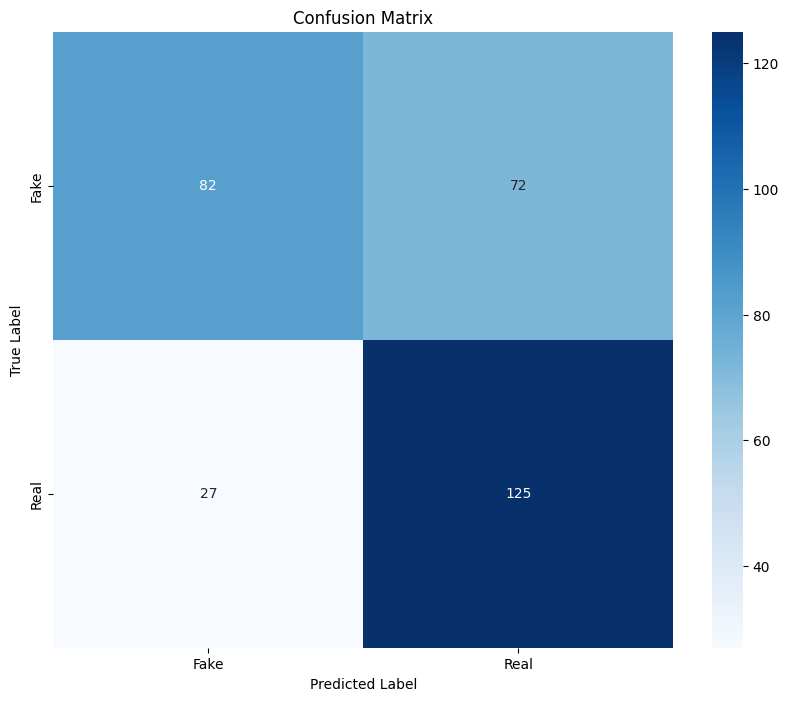

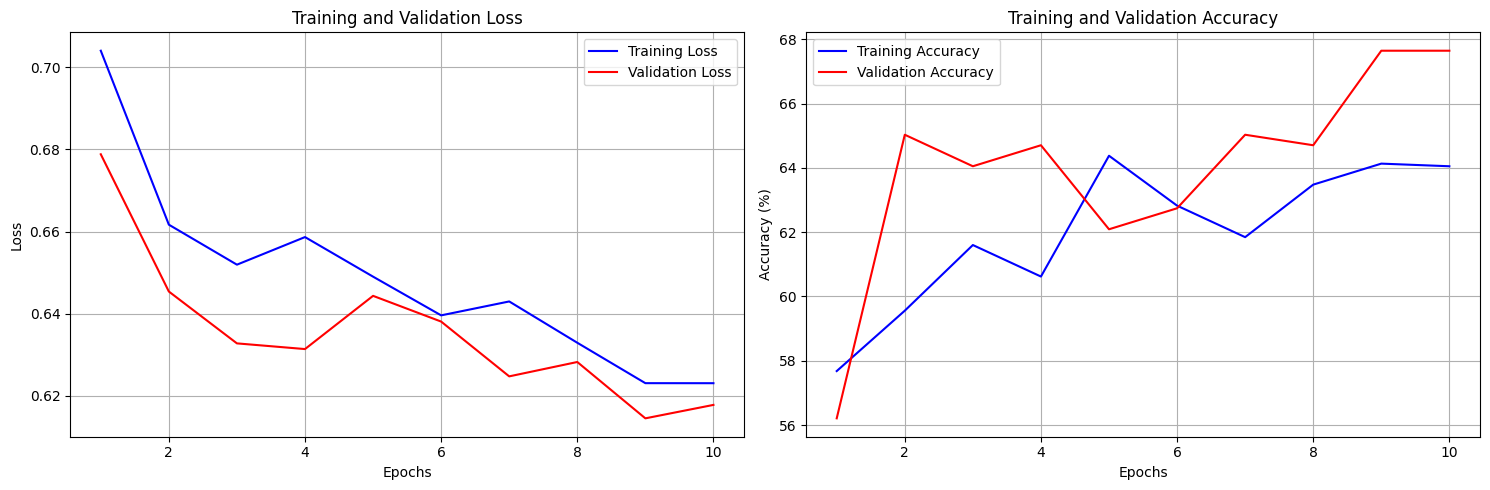


Final Model Performance Metrics:
Accuracy: 67.65%
Precision: 63.45%
Recall: 82.24%


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import numpy as np
from mamba_ssm import Mamba
import os
from sklearn.metrics import confusion_matrix, precision_score, recall_score, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

class MetricsTracker:
    def __init__(self):
        self.train_losses = []
        self.train_accuracies = []
        self.val_losses = []
        self.val_accuracies = []

    def update(self, train_loss, train_acc, val_loss, val_acc):
        self.train_losses.append(train_loss)
        self.train_accuracies.append(train_acc)
        self.val_losses.append(val_loss)
        self.val_accuracies.append(val_acc)

class VisionMambaClassifier(nn.Module):
    def __init__(self, image_size=224, patch_size=16, dim=512, depth=12):
        super().__init__()

        self.patch_size = patch_size
        self.num_patches = (image_size // patch_size) ** 2

        self.patch_embed = nn.Conv2d(3, dim, kernel_size=patch_size, stride=patch_size)
        nn.init.xavier_uniform_(self.patch_embed.weight)

        self.pos_embed = nn.Parameter(torch.zeros(1, self.num_patches, dim))
        nn.init.trunc_normal_(self.pos_embed, std=0.02)

        self.dropout = nn.Dropout(0.1)

        self.blocks = nn.ModuleList([
            nn.Sequential(
                nn.LayerNorm(dim),
                Mamba(
                    d_model=dim,
                    d_state=16,
                    d_conv=4,
                    expand=2
                ),
                nn.Dropout(0.1)
            )
            for _ in range(depth)
        ])

        self.norm = nn.LayerNorm(dim)
        self.head = nn.Sequential(
            nn.Linear(dim, dim // 2),
            nn.GELU(),
            nn.Dropout(0.1),
            nn.Linear(dim // 2, 2)
        )

    def forward(self, x):
        x = self.patch_embed(x)
        b, c, h, w = x.shape
        x = x.flatten(2).transpose(1, 2)
        x = x + self.pos_embed
        x = self.dropout(x)

        for block in self.blocks:
            x = x + block(x)

        x = x.mean(dim=1)
        x = self.norm(x)
        x = self.head(x)

        return x

class ImageDataset(Dataset):
    def __init__(self, data_dir, transform=None):
        self.data_dir = data_dir
        self.transform = transform
        self.images = []
        self.labels = []

        real_dir = os.path.join(data_dir, 'real')
        for img_name in os.listdir(real_dir):
            self.images.append(os.path.join(real_dir, img_name))
            self.labels.append(1)

        fake_dir = os.path.join(data_dir, 'fake')
        for img_name in os.listdir(fake_dir):
            self.images.append(os.path.join(fake_dir, img_name))
            self.labels.append(0)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = self.images[idx]
        image = Image.open(img_path).convert('RGB')
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, label

def train_model(model, train_loader, val_loader, num_epochs=10, device='cuda'):
    print("Starting training...")
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=0.01)
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs)

    metrics_tracker = MetricsTracker()
    model.metrics_tracker = metrics_tracker

    model = model.to(device)
    best_val_acc = 0.0

    for epoch in range(num_epochs):
        print(f"\nEpoch {epoch+1}/{num_epochs}")

        # Training phase
        model.train()
        train_loss = 0.0
        correct = 0
        total = 0

        for batch_idx, (images, labels) in enumerate(train_loader):
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)

            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()

            train_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

            if batch_idx % 10 == 0:
                print(f'Batch [{batch_idx}/{len(train_loader)}] Loss: {loss.item():.4f}')

        train_loss = train_loss/len(train_loader)
        train_acc = 100. * correct / total

        # Validation phase
        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0

        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)

                val_loss += loss.item()
                _, predicted = outputs.max(1)
                total += labels.size(0)
                correct += predicted.eq(labels).sum().item()

        val_loss = val_loss/len(val_loader)
        val_acc = 100. * correct / total

        metrics_tracker.update(train_loss, train_acc, val_loss, val_acc)
        scheduler.step()

        print(f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%')
        print(f'Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%')
        print(f'Learning Rate: {scheduler.get_last_lr()[0]:.6f}')

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            print(f"Saving best model with validation accuracy: {val_acc:.2f}%")
            torch.save({
                'model_state_dict': model.state_dict(),
                'metrics_tracker': metrics_tracker
            }, 'best_model.pth')

    return model, metrics_tracker

def evaluate_model(model, test_loader, device='cuda'):
    model.eval()
    all_preds = []
    all_labels = []
    all_probs = []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            probs = torch.softmax(outputs, dim=1)
            _, preds = torch.max(outputs, 1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())

    return np.array(all_preds), np.array(all_labels), np.array(all_probs)

def plot_confusion_matrix(true_labels, predictions, class_names=['Fake', 'Real']):
    plt.figure(figsize=(10, 8))
    cm = confusion_matrix(true_labels, predictions)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names,
                yticklabels=class_names)
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

def plot_training_curves(metrics_tracker):
    epochs = range(1, len(metrics_tracker.train_losses) + 1)

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    ax1.plot(epochs, metrics_tracker.train_losses, 'b-', label='Training Loss')
    ax1.plot(epochs, metrics_tracker.val_losses, 'r-', label='Validation Loss')
    ax1.set_title('Training and Validation Loss')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss')
    ax1.legend()
    ax1.grid(True)

    ax2.plot(epochs, metrics_tracker.train_accuracies, 'b-', label='Training Accuracy')
    ax2.plot(epochs, metrics_tracker.val_accuracies, 'r-', label='Validation Accuracy')
    ax2.set_title('Training and Validation Accuracy')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Accuracy (%)')
    ax2.legend()
    ax2.grid(True)

    plt.tight_layout()
    plt.show()

def calculate_metrics(true_labels, predictions, probabilities):
    accuracy = accuracy_score(true_labels, predictions)
    precision = precision_score(true_labels, predictions, average='binary')
    recall = recall_score(true_labels, predictions, average='binary')

    return {
        'accuracy': accuracy * 100,
        'precision': precision * 100,
        'recall': recall * 100,
    }

def main():
    # Set device
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")

    # Set up data transforms
    train_transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(10),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    val_transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    # Create datasets and dataloaders
    print("Loading datasets...")
    train_dataset = ImageDataset('/content/Dataset/Dataset/train', transform=train_transform)
    val_dataset = ImageDataset('/content/Dataset/Dataset/val', transform=val_transform)

    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
    val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=2)

    # Initialize and train model
    print("Initializing model...")
    model = VisionMambaClassifier()
    model, metrics_tracker = train_model(model, train_loader, val_loader)

    # Evaluate on validation set
    print("\nEvaluating model...")
    predictions, true_labels, probabilities = evaluate_model(model, val_loader, device)

    # Plot results
    print("\nPlotting results...")
    plot_confusion_matrix(true_labels, predictions)
    plot_training_curves(metrics_tracker)

    # Calculate and display metrics
    metrics = calculate_metrics(true_labels, predictions, probabilities)
    print("\nFinal Model Performance Metrics:")
    print(f"Accuracy: {metrics['accuracy']:.2f}%")
    print(f"Precision: {metrics['precision']:.2f}%")
    print(f"Recall: {metrics['recall']:.2f}%")

if __name__ == '__main__':
  import gc
  device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
  if device == 'cuda':
    torch.cuda.empty_cache()
    gc.collect()
  main()

In [ ]:
import torch
from torchvision import transforms
from PIL import Image

def test_single_image(image_path, model_path='best_model.pth', device='cuda'):
    """
    Test the model on a single image.

    Args:
        image_path (str): Path to the image file
        model_path (str): Path to the saved model checkpoint
        device (str): Device to run inference on ('cuda' or 'cpu')

    Returns:
        dict: Prediction results including class and confidence scores
    """
    # Set device
    device = torch.device(device if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")

    # Load model
    print("Loading model...")
    model = VisionMambaClassifier()
    checkpoint = torch.load(model_path, map_location=device)
    model.load_state_dict(checkpoint['model_state_dict'])
    model = model.to(device)
    model.eval()

    # Prepare image
    print("Processing image...")
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    image = Image.open(image_path).convert('RGB')
    image_tensor = transform(image).unsqueeze(0).to(device)

    # Make prediction
    print("Making prediction...")
    with torch.no_grad():
        outputs = model(image_tensor)
        probabilities = torch.softmax(outputs, dim=1)
        prediction = torch.argmax(outputs, dim=1)

    # Get prediction results
    pred_class = 'Real' if prediction.item() == 1 else 'Fake'
    probs = probabilities[0].cpu().numpy()

    results = {
        'prediction': pred_class,
        'confidence': f"{max(probs) * 100:.2f}%",
        'fake_probability': f"{probs[0] * 100:.2f}%",
        'real_probability': f"{probs[1] * 100:.2f}%"
    }

    # Print results
    print("\nPrediction Results:")
    print(f"Class: {results['prediction']}")
    print(f"Confidence: {results['confidence']}")
    print(f"Probability Breakdown:")
    print(f"- Fake: {results['fake_probability']}")
    print(f"- Real: {results['real_probability']}")

    return results

if __name__ == '__main__':
    # Example usage
    image_path = '/content/Dataset/Dataset/val/real/abarnvbtwb_9.png'  # Replace with your image path
    results = test_single_image(image_path)

Using device: cuda
Loading model...


<ipython-input-5-a17d8701159f>:24: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_path, map_location=device)


Processing image...
Making prediction...

Prediction Results:
Class: Real
Confidence: 96.07%
Probability Breakdown:
- Fake: 3.93%
- Real: 96.07%




```
**Training Improvement on Vision MAMBA for accuracy**
```



Using device: cuda
Loading datasets...
Initializing model...


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/21.4M [00:00<?, ?B/s]

Starting training...


<ipython-input-4-00deca58046e>:167: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()



Epoch 1/50


<ipython-input-4-00deca58046e>:188: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Batch [0/20] Loss: 0.7648
Batch [10/20] Loss: 0.6824
Train Loss: 0.7021, Train Acc: 54.33%
Val Loss: 0.6406, Val Acc: 64.71%
Learning Rate: 0.000027
Saving best model with validation accuracy: 64.71%

Epoch 2/50
Batch [0/20] Loss: 0.6277
Batch [10/20] Loss: 0.6273
Train Loss: 0.6329, Train Acc: 65.28%
Val Loss: 0.6063, Val Acc: 68.95%
Learning Rate: 0.000075
Saving best model with validation accuracy: 68.95%

Epoch 3/50
Batch [0/20] Loss: 0.5342
Batch [10/20] Loss: 0.5972
Train Loss: 0.5675, Train Acc: 73.53%
Val Loss: 0.5645, Val Acc: 72.55%
Learning Rate: 0.000135
Saving best model with validation accuracy: 72.55%

Epoch 4/50
Batch [0/20] Loss: 0.4487
Batch [10/20] Loss: 0.5186
Train Loss: 0.5052, Train Acc: 79.25%
Val Loss: 0.4500, Val Acc: 83.66%
Learning Rate: 0.000183
Saving best model with validation accuracy: 83.66%

Epoch 5/50
Batch [0/20] Loss: 0.4061
Batch [10/20] Loss: 0.3874
Train Loss: 0.4256, Train Acc: 84.56%
Val Loss: 0.4549, Val Acc: 83.33%
Learning Rate: 0.000200

Ep

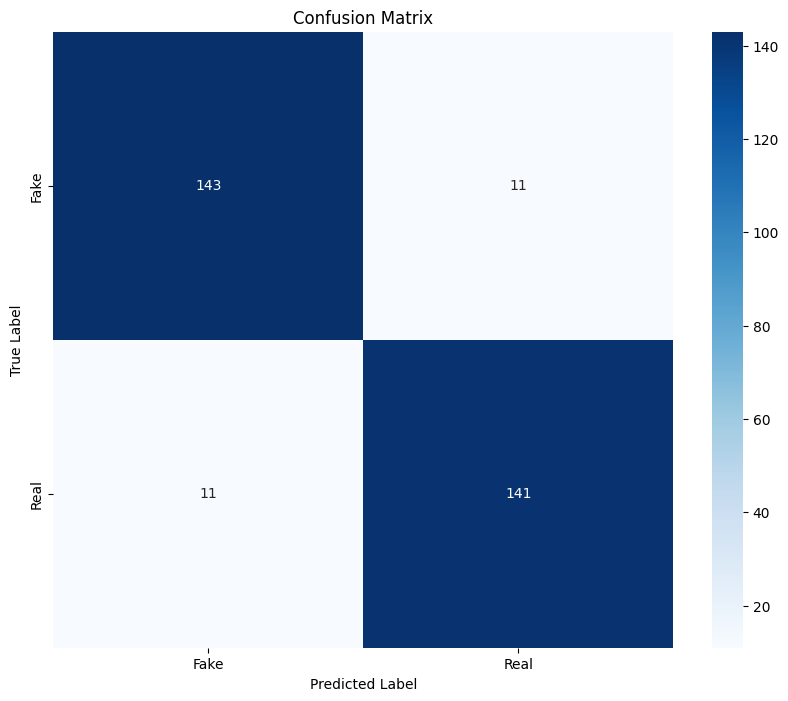

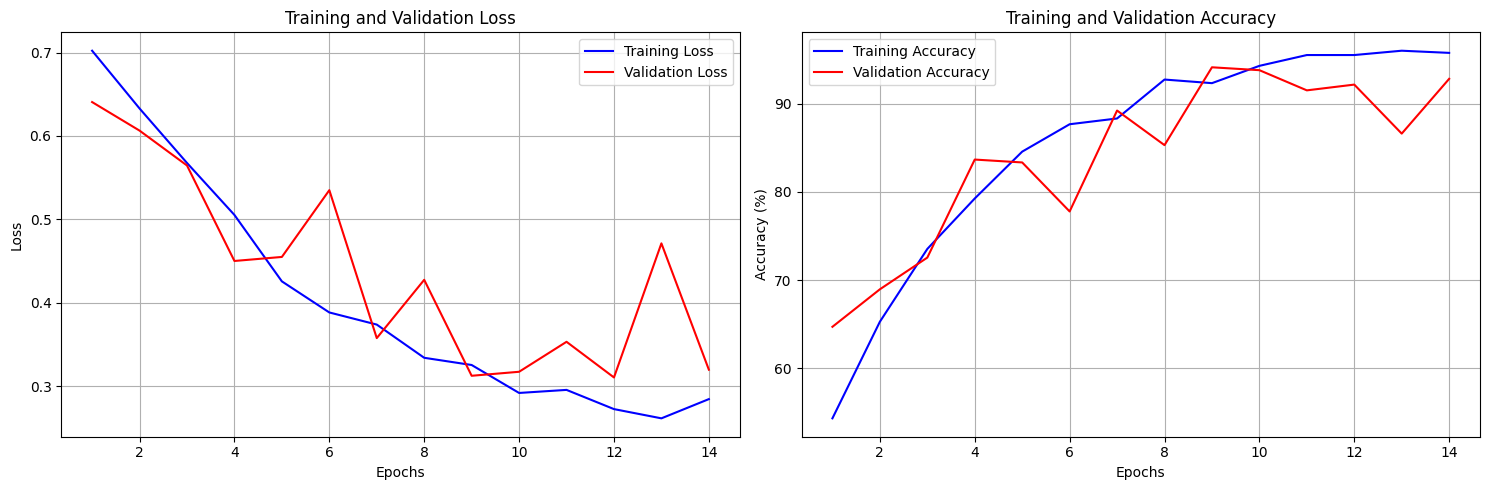


Final Model Performance Metrics:
Accuracy: 92.81%
Precision: 92.76%
Recall: 92.76%


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import numpy as np
from mamba_ssm import Mamba
import os
from sklearn.metrics import confusion_matrix, precision_score, recall_score, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import timm
from torch.cuda.amp import autocast, GradScaler

class MetricsTracker:
    def __init__(self):
        self.train_losses = []
        self.train_accuracies = []
        self.val_losses = []
        self.val_accuracies = []
        self.best_val_acc = 0
        self.epochs_without_improvement = 0

    def update(self, train_loss, train_acc, val_loss, val_acc):
        self.train_losses.append(train_loss)
        self.train_accuracies.append(train_acc)
        self.val_losses.append(val_loss)
        self.val_accuracies.append(val_acc)

        if val_acc > self.best_val_acc:
            self.best_val_acc = val_acc
            self.epochs_without_improvement = 0
            return True
        else:
            self.epochs_without_improvement += 1
            return False

class VisionMambaClassifier(nn.Module):
    def __init__(self, image_size=224, patch_size=16, dim=768, depth=24):
        super().__init__()

        # Initialize backbone
        self.backbone = timm.create_model('efficientnet_b0', pretrained=True, features_only=True)
        backbone_channels = self.backbone.feature_info[-1]['num_chs']

        # Calculate the output size from backbone
        with torch.no_grad():
            dummy_input = torch.zeros(1, 3, image_size, image_size)
            features = self.backbone(dummy_input)[-1]
            feature_size = features.shape[-1]  # Should be 7 for 224x224 input

        self.patch_size = patch_size
        self.num_patches = (feature_size * feature_size)

        # Fixed patch embedding to handle 7x7 feature maps
        self.patch_embed = nn.Sequential(
            nn.Conv2d(backbone_channels, dim, kernel_size=1),
            nn.LayerNorm([dim, feature_size, feature_size]),
            nn.GELU()
        )

        self.pos_embed = nn.Parameter(torch.zeros(1, self.num_patches, dim))
        nn.init.trunc_normal_(self.pos_embed, std=0.02)

        self.dropout = nn.Dropout(0.2)

        # Deeper Mamba blocks with skip connections
        self.blocks = nn.ModuleList([
            nn.Sequential(
                nn.LayerNorm(dim),
                Mamba(
                    d_model=dim,
                    d_state=32,
                    d_conv=8,
                    expand=4
                ),
                nn.Dropout(0.2)
            )
            for _ in range(depth)
        ])

        self.norm = nn.LayerNorm(dim)
        self.head = nn.Sequential(
            nn.Linear(dim, dim),
            nn.LayerNorm(dim),
            nn.GELU(),
            nn.Dropout(0.2),
            nn.Linear(dim, dim // 2),
            nn.LayerNorm(dim // 2),
            nn.GELU(),
            nn.Dropout(0.2),
            nn.Linear(dim // 2, 2)
        )

    def forward(self, x):
        # Extract features using EfficientNet backbone
        features = self.backbone(x)[-1]

        # Process through patch embedding
        x = self.patch_embed(features)
        b, c, h, w = x.shape
        x = x.flatten(2).transpose(1, 2)

        # Ensure pos_embed matches the sequence length
        if x.size(1) != self.pos_embed.size(1):
            x = x + self.pos_embed[:, :x.size(1), :]
        else:
            x = x + self.pos_embed

        x = self.dropout(x)

        # Process through Mamba blocks with residual connections
        for block in self.blocks:
            x = x + block(x)

        # Global average pooling and classification
        x = x.mean(dim=1)
        x = self.norm(x)
        x = self.head(x)

        return x

class ImageDataset(Dataset):
    def __init__(self, data_dir, transform=None):
        self.data_dir = data_dir
        self.transform = transform
        self.images = []
        self.labels = []

        real_dir = os.path.join(data_dir, 'real')
        for img_name in os.listdir(real_dir):
            self.images.append(os.path.join(real_dir, img_name))
            self.labels.append(1)

        fake_dir = os.path.join(data_dir, 'fake')
        for img_name in os.listdir(fake_dir):
            self.images.append(os.path.join(fake_dir, img_name))
            self.labels.append(0)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = self.images[idx]
        image = Image.open(img_path).convert('RGB')
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, label

def train_model(model, train_loader, val_loader, num_epochs=50, device='cuda'):
    print("Starting training...")
    criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
    optimizer = optim.AdamW(model.parameters(), lr=2e-4, weight_decay=0.05)
    scheduler = optim.lr_scheduler.OneCycleLR(
        optimizer,
        max_lr=2e-4,
        epochs=num_epochs,
        steps_per_epoch=len(train_loader),
        pct_start=0.1
    )

    scaler = GradScaler()
    metrics_tracker = MetricsTracker()
    model.metrics_tracker = metrics_tracker

    model = model.to(device)
    early_stopping_patience = 5

    for epoch in range(num_epochs):
        print(f"\nEpoch {epoch+1}/{num_epochs}")

        # Training phase
        model.train()
        train_loss = 0.0
        correct = 0
        total = 0

        for batch_idx, (images, labels) in enumerate(train_loader):
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()

            with autocast():
                outputs = model(images)
                loss = criterion(outputs, labels)

            scaler.scale(loss).backward()
            scaler.unscale_(optimizer)
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            scaler.step(optimizer)
            scaler.update()
            scheduler.step()

            train_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

            if batch_idx % 10 == 0:
                print(f'Batch [{batch_idx}/{len(train_loader)}] Loss: {loss.item():.4f}')

        train_loss = train_loss/len(train_loader)
        train_acc = 100. * correct / total

        # Validation phase
        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0

        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)

                val_loss += loss.item()
                _, predicted = outputs.max(1)
                total += labels.size(0)
                correct += predicted.eq(labels).sum().item()

        val_loss = val_loss/len(val_loader)
        val_acc = 100. * correct / total

        improved = metrics_tracker.update(train_loss, train_acc, val_loss, val_acc)

        print(f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%')
        print(f'Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%')
        print(f'Learning Rate: {scheduler.get_last_lr()[0]:.6f}')

        if improved:
            print(f"Saving best model with validation accuracy: {val_acc:.2f}%")
            torch.save({
                'model_state_dict': model.state_dict(),
                'metrics_tracker': metrics_tracker
            }, 'best_model.pth')

        if metrics_tracker.epochs_without_improvement >= early_stopping_patience:
            print(f"Early stopping triggered after {early_stopping_patience} epochs without improvement")
            break

    return model, metrics_tracker

def evaluate_model(model, test_loader, device='cuda'):
    model.eval()
    all_preds = []
    all_labels = []
    all_probs = []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            probs = torch.softmax(outputs, dim=1)
            _, preds = torch.max(outputs, 1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())

    return np.array(all_preds), np.array(all_labels), np.array(all_probs)

def plot_confusion_matrix(true_labels, predictions, class_names=['Fake', 'Real']):
    plt.figure(figsize=(10, 8))
    cm = confusion_matrix(true_labels, predictions)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names,
                yticklabels=class_names)
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

def plot_training_curves(metrics_tracker):
    epochs = range(1, len(metrics_tracker.train_losses) + 1)

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    ax1.plot(epochs, metrics_tracker.train_losses, 'b-', label='Training Loss')
    ax1.plot(epochs, metrics_tracker.val_losses, 'r-', label='Validation Loss')
    ax1.set_title('Training and Validation Loss')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss')
    ax1.legend()
    ax1.grid(True)

    ax2.plot(epochs, metrics_tracker.train_accuracies, 'b-', label='Training Accuracy')
    ax2.plot(epochs, metrics_tracker.val_accuracies, 'r-', label='Validation Accuracy')
    ax2.set_title('Training and Validation Accuracy')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Accuracy (%)')
    ax2.legend()
    ax2.grid(True)

    plt.tight_layout()
    plt.show()

def calculate_metrics(true_labels, predictions, probabilities):
    accuracy = accuracy_score(true_labels, predictions)
    precision = precision_score(true_labels, predictions, average='binary')
    recall = recall_score(true_labels, predictions, average='binary')

    return {
        'accuracy': accuracy * 100,
        'precision': precision * 100,
        'recall': recall * 100,
    }


def main():
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")

    # Enhanced data augmentation
    train_transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        transforms.RandomRotation(15),
        transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.1),
        transforms.RandomAffine(degrees=10, translate=(0.1, 0.1), scale=(0.9, 1.1)),
        transforms.RandomAutocontrast(),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    val_transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    # Create datasets and dataloaders with larger batch size
    print("Loading datasets...")
    train_dataset = ImageDataset('/content/Dataset/Dataset/train', transform=train_transform)
    val_dataset = ImageDataset('/content/Dataset/Dataset/val', transform=val_transform)

    train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=4, pin_memory=True)
    val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False, num_workers=4, pin_memory=True)

    # Initialize and train model
    print("Initializing model...")
    model = VisionMambaClassifier()
    model, metrics_tracker = train_model(model, train_loader, val_loader)

    # Evaluate and plot results
    print("\nEvaluating model...")
    predictions, true_labels, probabilities = evaluate_model(model, val_loader, device)
    plot_confusion_matrix(true_labels, predictions)
    plot_training_curves(metrics_tracker)

    metrics = calculate_metrics(true_labels, predictions, probabilities)
    print("\nFinal Model Performance Metrics:")
    print(f"Accuracy: {metrics['accuracy']:.2f}%")
    print(f"Precision: {metrics['precision']:.2f}%")
    print(f"Recall: {metrics['recall']:.2f}%")

if __name__ == '__main__':
    import gc
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    if device == 'cuda':
        torch.cuda.empty_cache()
        gc.collect()
    main()

**Testing**

In [ ]:
import torch
from torchvision import transforms
from PIL import Image

class VisionMambaClassifier(nn.Module):
    def __init__(self, image_size=224, patch_size=16, dim=768, depth=24):
        super().__init__()

        # Initialize backbone
        self.backbone = timm.create_model('efficientnet_b0', pretrained=True, features_only=True)
        backbone_channels = self.backbone.feature_info[-1]['num_chs']

        # Calculate the output size from backbone
        with torch.no_grad():
            dummy_input = torch.zeros(1, 3, image_size, image_size)
            features = self.backbone(dummy_input)[-1]
            feature_size = features.shape[-1]  # Should be 7 for 224x224 input

        self.patch_size = patch_size
        self.num_patches = (feature_size * feature_size)

        # Fixed patch embedding to handle 7x7 feature maps
        self.patch_embed = nn.Sequential(
            nn.Conv2d(backbone_channels, dim, kernel_size=1),
            nn.LayerNorm([dim, feature_size, feature_size]),
            nn.GELU()
        )

        self.pos_embed = nn.Parameter(torch.zeros(1, self.num_patches, dim))
        nn.init.trunc_normal_(self.pos_embed, std=0.02)

        self.dropout = nn.Dropout(0.2)

        # Deeper Mamba blocks with skip connections
        self.blocks = nn.ModuleList([
            nn.Sequential(
                nn.LayerNorm(dim),
                Mamba(
                    d_model=dim,
                    d_state=32,
                    d_conv=8,
                    expand=4
                ),
                nn.Dropout(0.2)
            )
            for _ in range(depth)
        ])

        self.norm = nn.LayerNorm(dim)
        self.head = nn.Sequential(
            nn.Linear(dim, dim),
            nn.LayerNorm(dim),
            nn.GELU(),
            nn.Dropout(0.2),
            nn.Linear(dim, dim // 2),
            nn.LayerNorm(dim // 2),
            nn.GELU(),
            nn.Dropout(0.2),
            nn.Linear(dim // 2, 2)
        )

    def forward(self, x):
        # Extract features using EfficientNet backbone
        features = self.backbone(x)[-1]

        # Process through patch embedding
        x = self.patch_embed(features)
        b, c, h, w = x.shape
        x = x.flatten(2).transpose(1, 2)

        # Ensure pos_embed matches the sequence length
        if x.size(1) != self.pos_embed.size(1):
            x = x + self.pos_embed[:, :x.size(1), :]
        else:
            x = x + self.pos_embed

        x = self.dropout(x)

        # Process through Mamba blocks with residual connections
        for block in self.blocks:
            x = x + block(x)

        # Global average pooling and classification
        x = x.mean(dim=1)
        x = self.norm(x)
        x = self.head(x)

        return x

def test_single_image(image_path, model_path='best_model.pth', device='cuda'):
    """
    Test the model on a single image.

    Args:
        image_path (str): Path to the image file
        model_path (str): Path to the saved model checkpoint
        device (str): Device to run inference on ('cuda' or 'cpu')

    Returns:
        dict: Prediction results including class and confidence scores
    """
    # Set device
    device = torch.device(device if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")

    # Load model
    print("Loading model...")
    model = VisionMambaClassifier()
    checkpoint = torch.load(model_path, map_location=device)
    model.load_state_dict(checkpoint['model_state_dict'])
    model = model.to(device)
    model.eval()

    # Prepare image
    print("Processing image...")
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    image = Image.open(image_path).convert('RGB')
    image_tensor = transform(image).unsqueeze(0).to(device)

    # Make prediction
    print("Making prediction...")
    with torch.no_grad():
        outputs = model(image_tensor)
        probabilities = torch.softmax(outputs, dim=1)
        prediction = torch.argmax(outputs, dim=1)

    # Get prediction results
    pred_class = 'Real' if prediction.item() == 1 else 'Fake'
    probs = probabilities[0].cpu().numpy()

    results = {
        'prediction': pred_class,
        'confidence': f"{max(probs) * 100:.2f}%",
        'fake_probability': f"{probs[0] * 100:.2f}%",
        'real_probability': f"{probs[1] * 100:.2f}%"
    }

    # Print results
    print("\nPrediction Results:")
    print(f"Class: {results['prediction']}")
    print(f"Confidence: {results['confidence']}")
    print(f"Probability Breakdown:")
    print(f"- Fake: {results['fake_probability']}")
    print(f"- Real: {results['real_probability']}")

    return results

if __name__ == '__main__':
    # Example usage
    image_path = '/content/Dataset/Dataset/val/real/abarnvbtwb_9.png'  # Replace with your image path
    results = test_single_image(image_path)

Using device: cuda
Loading model...


<ipython-input-5-ba736d9d0796>:109: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_path, map_location=device)


Processing image...
Making prediction...

Prediction Results:
Class: Real
Confidence: 93.44%
Probability Breakdown:
- Fake: 6.56%
- Real: 93.44%
